In this lab you will do the following steps in order:

1. How transformers works
2. Sequence-to-sequence transformer model application




In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_30913/2152417943.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

## 1. The Transformer architecture

In the first part of this notebook, we will implement the Transformer architecture by hand. As the architecture is so popular, there already exists a Pytorch module `nn.Transformer` ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)) and a [tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) on how to use it for next token prediction. However, we will implement it here ourselves, to get through to the smallest details.

### What is Attention?

The attention mechanism describes a recent new group of layers in neural networks that has attracted a lot of interest in the past few years, especially in sequence tasks. There are a lot of different possible definitions of "attention" in the literature, but the one we will use here is the following: _the attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and elements' keys_. So what does this exactly mean? The goal is to take an average over the features of multiple elements. However, instead of weighting each element equally, we want to weight them depending on their actual values. In other words, we want to dynamically decide on which inputs we want to "attend" more than others. In particular, an attention mechanism has usually four parts we need to specify:

* **Query**: The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.
* **Keys**: For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is "offering", or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.
* **Values**: For each input element, we also have a value vector. This feature vector is the one we want to average over.
* **Score function**: To rate which elements we want to pay attention to, we need to specify a score function $f_{attn}$. The score function takes the query and a key as input, and output the score/attention weight of the query-key pair. It is usually implemented by simple similarity metrics like a dot product, or a small MLP.


The weights of the average are calculated by a softmax over all score function outputs. Hence, we assign those value vectors a higher weight whose corresponding key is most similar to the query. If we try to describe it with pseudo-math, we can write:

$$
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i
$$

Visually, we can show the attention over a sequence of words as follows:

<center width="100%" style="padding:25px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/attention_example.svg?raw=1" width="750px"></center>

For every word, we have one key and one value vector. The query is compared to all keys with a score function (in this case the dot product) to determine the weights. The softmax is not visualized for simplicity. Finally, the value vectors of all words are averaged using the attention weights.

Most attention mechanisms differ in terms of what queries they use, how the key and value vectors are defined, and what score function is used. The attention applied inside the Transformer architecture is called **self-attention**. In self-attention, each sequence element provides a key, value, and query. For each element, we perform an attention layer where based on its query, we check the similarity of the all sequence elements' keys, and returned a different, averaged value vector for each element. We will now go into a bit more detail by first looking at the specific implementation of the attention mechanism which is in the Transformer case the scaled dot product attention.

### Scaled Dot Product Attention

The core concept behind self-attention is the scaled dot product attention. Our goal is to have an attention mechanism with which any element in a sequence can attend to any other while still being efficient to compute. The dot product attention takes as input a set of queries $Q\in\mathbb{R}^{T\times d_k}$, keys $K\in\mathbb{R}^{T\times d_k}$ and values $V\in\mathbb{R}^{T\times d_v}$ where $T$ is the sequence length, and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively. For simplicity, we neglect the batch dimension for now. The attention value from element $i$ to $j$ is based on its similarity of the query $Q_i$ and key $K_j$, using the dot product as the similarity metric. In math, we calculate the dot product attention as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $T\times T$. Each row represents the attention logits for a specific element $i$ to all other elements in the sequence. On these, we apply a softmax and multiply with the value vector to obtain a weighted mean (the weights being determined by the attention). Another perspective on this attention mechanism offers the computation graph which is visualized below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/scaled_dot_product_attn.svg?raw=1" width="210px"></center>

One aspect we haven't discussed yet is the scaling factor of $1/\sqrt{d_k}$. This scaling factor is crucial to maintain an appropriate variance of attention values after initialization. Remember that we intialize our layers with the intention of having equal variance throughout the model, and hence, $Q$ and $K$ might also have a variance close to $1$. However, performing a dot product over two vectors with a variance $\sigma^2$ results in a scalar having $d_k$-times higher variance:

The block `Mask (opt.)` in the diagram above represents the optional masking of specific entries in the attention matrix. This is for instance used if we stack multiple sequences with different lengths into a batch. To still benefit from parallelization in PyTorch, we pad the sentences to the same length and mask out the padding tokens during the calculation of the attention values. This is usually done by setting the respective attention logits to a very low value.

After we have discussed the details of the scaled dot product attention block, we can write a function below which computes the output features given the triple of queries, keys, and values:

In [2]:
def scaled_dot_product(q, k, v, mask=None):
    """
    Implements scaled dot-product attention.

    Args:
        q: Query vectors (shape: batch_size, num_heads, seq_len, d_k).
        k: Key vectors (shape: batch_size, num_heads, seq_len, d_k).
        v: Value vectors (shape: batch_size, num_heads, seq_len, d_v).
        mask: Optional mask to prevent attention weights on padding tokens (shape: batch_size, 1, 1, seq_len).

    Returns:
        values: Weighted sum of value vectors (shape: batch_size, num_heads, seq_len, d_v).
        attention: Attention weights (shape: batch_size, num_heads, seq_len, seq_len).
    """

    # Dimension of the key vector (d_k)
    d_k = q.size()[-1]

    # Calculate attention logits (scores) using matrix multiplication
    attn_logits = torch.matmul(q, k.transpose(-2, -1))

    # Scale the logits by dividing by the square root of d_k
    attn_logits = attn_logits / math.sqrt(d_k)

    # Apply masking if provided
    if mask is not None:
        # Set masked elements in attn_logits to a very negative value (-9e15)
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)

    # Compute attention weights using softmax along the last dimension
    attention = F.softmax(attn_logits, dim=-1)

    # Weight the value vectors using the attention weights
    values = torch.matmul(attention, v)

    # Return the weighted values and attention weights
    return values, attention


Note that our code above supports any additional dimensionality in front of the sequence length so that we can also use it for batches. However, for a better understanding, let's generate a few random queries, keys, and value vectors, and calculate the attention outputs:

Seed set to 42


Q (Query Vectors):
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K (Key Vectors):
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V (Value Vectors):
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values (Weighted Sum of V):
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention Weights:


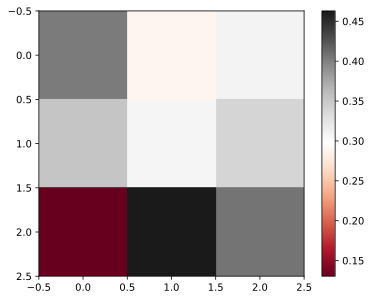

In [3]:
# Set random seed for reproducibility
pl.seed_everything(42)  # Assuming you meant `plt.seed_everything`

# Define sequence length and key/value vector dimension
seq_len, d_k = 3, 2

# Generate random query, key, and value vectors
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)

# Perform scaled dot-product attention
values, attention = scaled_dot_product(q, k, v)

# Print the tensors
print("Q (Query Vectors):\n", q)
print("K (Key Vectors):\n", k)
print("V (Value Vectors):\n", v)
print("Values (Weighted Sum of V):\n", values)

# Optional visualization of attention weights (requires matplotlib)
print("Attention Weights:")
plt.imshow(attention.detach().cpu().numpy(), cmap="RdGy")  # Detach and move to CPU for visualization
plt.colorbar()
plt.show()

Before continuing, make sure you can follow the calculation of the specific values here, and also check it by hand. It is important to fully understand how the scaled dot product attention is calculated.

### Multi-Head Attention

The scaled dot product attention allows a network to attend over a sequence. However, often there are multiple different aspects a sequence element wants to attend to, and a single weighted average is not a good option for it. This is why we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys, and sub-values, which we pass through the scaled dot product attention independently. Afterward, we concatenate the heads and combine them with a final weight matrix. Mathematically, we can express this operation as:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer with the learnable parameters $W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$, and $W^{O}\in\mathbb{R}^{h\cdot d_v\times d_{out}}$ ($D$ being the input dimensionality). Expressed in a computational graph, we can visualize it as below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/multihead_attention.svg?raw=1" width="230px"></center>

How are we applying a Multi-Head Attention layer in a neural network, where we don't have an arbitrary query, key, and value vector as input? Looking at the computation graph above, a simple but effective implementation is to set the current feature map in a NN, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$ ($B$ being the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$). The consecutive weight matrices $W^{Q}$, $W^{K}$, and $W^{V}$ can transform $X$ to the corresponding feature vectors that represent the queries, keys, and values of the input. Using this approach, we can implement the Multi-Head Attention module below.

In [4]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

One crucial characteristic of the multi-head attention is that it is permutation-equivariant with respect to its inputs. This means that if we switch two input elements in the sequence, e.g. $X_1\leftrightarrow X_2$ (neglecting the batch dimension for now), the output is exactly the same besides the elements 1 and 2 switched. Hence, the multi-head attention is actually looking at the input not as a sequence, but as a set of elements. This property makes the multi-head attention block and the Transformer architecture so powerful and widely applicable! But what if the order of the input is actually important for solving the task, like language modeling? The answer is to encode the position in the input features, which we will take a closer look at later (topic _Positional encodings_ below).

Before moving on to creating the Transformer architecture, we can compare the self-attention operation with our other common layer competitors for sequence data: convolutions and recurrent neural networks. Below you can find a table by [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762) on the complexity per layer, the number of sequential operations, and maximum path length. The complexity is measured by the upper bound of the number of operations to perform, while the maximum path length represents the maximum number of steps a forward or backward signal has to traverse to reach any other position. The lower this length, the better gradient signals can backpropagate for long-range dependencies. Let's take a look at the table below:


<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/comparison_conv_rnn.svg?raw=1" width="600px"></center>

$n$ is the sequence length, $d$ is the representation dimension and $k$ is the kernel size of convolutions. In contrast to recurrent networks, the self-attention layer can parallelize all its operations making it much faster to execute for smaller sequence lengths. However, when the sequence length exceeds the hidden dimensionality, self-attention becomes more expensive than RNNs. One way of reducing the computational cost for long sequences is by restricting the self-attention to a neighborhood of inputs to attend over, denoted by $r$. Nevertheless, there has been recently a lot of work on more efficient Transformer architectures that still allow long dependencies, of which you can find an overview in the paper by [Tay et al. (2020)](https://arxiv.org/abs/2009.06732) if interested.

### Transformer Encoder

Next, we will look at how to apply the multi-head attention block inside the Transformer architecture. Originally, the Transformer model was designed for machine translation. Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language and generates an attention-based representation. On the other hand, the decoder attends over the encoded information and generates the translated sentence in an autoregressive manner, as in a standard RNN. While this structure is extremely useful for Sequence-to-Sequence tasks with the necessity of autoregressive decoding, we will focus here on the encoder part. Many advances in NLP have been made using pure encoder-based Transformer models (if interested, models include the [BERT](https://arxiv.org/abs/1810.04805)-family, the [Vision Transformer](https://arxiv.org/abs/2010.11929), and more), and in our tutorial, we will also mainly focus on the encoder part. If you have understood the encoder architecture, the decoder is a very small step to implement as well. The full Transformer architecture looks as follows (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/transformer_architecture.svg?raw=1" width="400px"></center>

The encoder consists of $N$ identical blocks that are applied in sequence. Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above. The output is added to the original input using a residual connection, and we apply a consecutive Layer Normalization on the sum. Overall, it calculates $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$ ($x$ being $Q$, $K$ and $V$ input to the attention layer). The residual connection is crucial in the Transformer architecture for two reasons:

1. Similar to ResNets, Transformers are designed to be very deep. Some models contain more than 24 blocks in the encoder. Hence, the residual connections are crucial for enabling a smooth gradient flow through the model.
2. Without the residual connection, the information about the original sequence is lost. Remember that the Multi-Head Attention layer ignores the position of elements in a sequence, and can only learn it based on the input features. Removing the residual connections would mean that this information is lost after the first attention layer (after initialization), and with a randomly initialized query and key vector, the output vectors for position $i$ has no relation to its original input. All outputs of the attention are likely to represent similar/same information, and there is no chance for the model to distinguish which information came from which input element. An alternative option to residual connection would be to fix at least one head to focus on its original input, but this is very inefficient and does not have the benefit of the improved gradient flow.

The Layer Normalization also plays an important role in the Transformer architecture as it enables faster training and provides small regularization. Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence. We are not using Batch Normalization because it depends on the batch size which is often small with Transformers (they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language as the features of words tend to have a much higher variance (there are many, very rare words which need to be considered for a good distribution estimate).

Additionally to the Multi-Head Attention, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically. Specifically, the model uses a Linear$\to$ReLU$\to$Linear MLP. The full transformation including the residual connection can be expressed as:  

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

This MLP adds extra complexity to the model and allows transformations on each sequence element separately. You can imagine as this allows the model to "post-process" the new information added by the previous Multi-Head Attention, and prepare it for the next attention block. Usually, the inner dimensionality of the MLP is 2-8$\times$ larger than $d_{\text{model}}$, i.e. the dimensionality of the original input $x$. The general advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.

Finally, after looking at all parts of the encoder architecture, we can start implementing it below. We first start by implementing a single encoder block. Additionally to the layers described above, we will add dropout layers in the MLP and on the output of the MLP and Multi-Head Attention for regularization.

In [5]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

Based on this block, we can implement a module for the full Transformer encoder. Additionally to a forward function that iterates through the sequence of encoder blocks, we also provide a function called `get_attention_maps`. The idea of this function is to return the attention probabilities for all Multi-Head Attention blocks in the encoder. This helps us in understanding, and in a sense, explaining the model. However, the attention probabilities should be interpreted with a grain of salt as it does not necessarily reflect the true interpretation of the model (there is a series of papers about this, including [Attention is not Explanation](https://arxiv.org/abs/1902.10186) and [Attention is not not Explanation](https://arxiv.org/abs/1908.04626)).

In [6]:
class TransformerEncoder(nn.Module):
    """
    Transformer encoder class that stacks multiple EncoderBlock instances.

    Args:
        num_layers (int): Number of encoder layers to be stacked.
        **block_args (dict): Keyword arguments to be passed to the EncoderBlock constructor.
    """

    def __init__(self, num_layers, **block_args):
        super().__init__()
        """
        Initializes the TransformerEncoder module.

        - Creates a ModuleList named 'layers' to hold the stacked EncoderBlocks.
        - Iterates 'num_layers' times, creating an EncoderBlock instance with
          the provided 'block_args' for each layer and adding it to the 'layers' list.
        """
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        """
        Performs the forward pass through the stacked encoder layers.

        Args:
            x (tensor): Input sequence to be processed by the encoder.
            mask (tensor, optional): Masking tensor to prevent attention to padding tokens.

        Returns:
            tensor: Final output after processing through all encoder layers.
        """
        for l in self.layers:
            x = l(x, mask=mask)  # Pass input through current encoder layer
        return x

    def get_attention_maps(self, x, mask=None):
        """
        Retrieves attention maps from the self-attention mechanism in each encoder layer.

        Args:
            x (tensor): Input sequence to be processed by the encoder.
            mask (tensor, optional): Masking tensor to prevent attention to padding tokens.

        Returns:
            list: List of attention maps generated by each encoder layer.
        """
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            # Extract attention map and append to list
            attention_maps.append(attn_map)
            x = l(x)  # Pass input through current encoder layer
        return attention_maps


### Positional encoding

We previously discussed that the Multi-Head Attention block is permutation-equivariant, meaning it can't inherently distinguish the order of elements within a sequence. However, in tasks like language understanding, word order is crucial for interpreting the meaning of the sentence.

#### Traditional Positional Encoding (Sinusoidal):

The typical approach in Transformers utilizes sinusoidal functions of different frequencies to inject positional information into the input features. These functions inherently capture relative position based on their frequency.
Challenges of Sinusoidal Encoding:

#### Learnable Positional Encoding with Linear Layer

The provided code implements an alternative approach using a learnable linear layer:
```
self.positional_encoding = nn.Linear(model_dim, model_dim)
```

How it Works:

This linear layer takes the model_dim and outputs a vector of size model dimension.
During training, this layer learns to represent positional information for different sequence positions within this vector.

### Learning rate warm-up

One commonly used technique for training a Transformer is learning rate warm-up. This means that we gradually increase the learning rate from 0 on to our originally specified learning rate in the first few iterations. Thus, we slowly start learning instead of taking very large steps from the beginning. In fact, training a deep Transformer without learning rate warm-up can make the model diverge and achieve a much worse performance on training and testing. Take for instance the following plot by [Liu et al. (2019)](https://arxiv.org/pdf/1908.03265.pdf) comparing Adam-vanilla (i.e. Adam without warm-up) vs Adam with a warm-up:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/warmup_loss_plot.svg?raw=1" width="350px"></center>

Clearly, the warm-up is a crucial hyperparameter in the Transformer architecture. Why is it so important? There are currently two common explanations. Firstly, Adam uses the bias correction factors which however can lead to a higher variance in the adaptive learning rate during the first iterations. Improved optimizers like [RAdam](https://arxiv.org/abs/1908.03265) have been shown to overcome this issue, not requiring warm-up for training Transformers. Secondly, the iteratively applied Layer Normalization across layers can lead to very high gradients during the first iterations, which can be solved by using [Pre-Layer Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf) (similar to Pre-Activation ResNet), or replacing Layer Normalization by other techniques ([Adaptive Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf), [Power Normalization](https://arxiv.org/abs/2003.07845)).

Nevertheless, many applications and papers still use the original Transformer architecture with Adam, because warm-up is a simple, yet effective way of solving the gradient problem in the first iterations. There are many different schedulers we could use. For instance, the original Transformer paper used an exponential decay scheduler with a warm-up. However, the currently most popular scheduler is the cosine warm-up scheduler, which combines warm-up with a cosine-shaped learning rate decay. We can implement it below, and visualize the learning rate factor over epochs.

In [7]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    """
    Custom learning rate scheduler that combines cosine annealing with warmup.

    Args:
        optimizer (torch.optim.Optimizer): The optimizer whose learning rate will be scheduled.
        warmup (int): Number of epochs to linearly increase the learning rate.
        max_iters (int): Total number of training iterations (epochs).
    """

    def __init__(self, optimizer, warmup, max_iters):
        """
        Initializes the CosineWarmupScheduler instance.

        - Stores the optimizer, warmup duration, and maximum training iterations.
        - Calls the superclass constructor to initialize the base learning rate scheduler.
        """
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        """
        Calculates the learning rates for all param groups in the optimizer.

        - Calls the get_lr_factor method to compute a learning rate factor based on the current epoch.
        - Multiplies the base learning rates in each param group by the learning rate factor to get the final learning rates.
        - Returns a list containing the adjusted learning rates for all param groups.
        """
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        """
        Computes the learning rate factor based on the current epoch.

        - Implements a cosine annealing schedule with a warmup phase.
        - Calculates a learning rate factor using a cosine function with period equal to the total training iterations.
        - During the warmup phase (<= warmup epochs), linearly increases the learning rate factor from 0 to 1.
        - Returns the learning rate factor used to adjust the base learning rates.
        """
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor


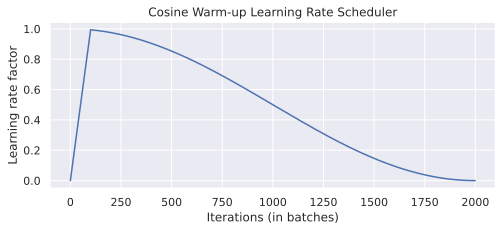

In [8]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In the first 100 iterations, we increase the learning rate factor from 0 to 1, whereas for all later iterations, we decay it using the cosine wave. Pre-implementations of this scheduler can be found in the popular NLP Transformer library [huggingface](https://huggingface.co/transformers/main_classes/optimizer_schedules.html?highlight=cosine#transformers.get_cosine_schedule_with_warmup).

### PyTorch Lightning Module

Finally, we can embed the Transformer architecture into a PyTorch lightning module. PyTorch Lightning simplifies our training and test code, as well as structures the code nicely in separate functions. We will implement a template for a classifier based on the Transformer encoder. Thereby, we have a prediction output per sequence element. If we would need a classifier over the whole sequence, the common approach is to add an additional `[CLS]` token to the sequence, representing the classifier token. However, here we focus on tasks where we have an output per element.

Additionally to the Transformer architecture, we add a small input network (maps input dimensions to model dimensions), the positional encoding, and an output network (transforms output encodings to predictions). We also add the learning rate scheduler, which takes a step each iteration instead of once per epoch. This is needed for the warmup and the smooth cosine decay. The training, validation, and test step is left empty for now and will be filled for our task-specific models.

In [9]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, seq_len, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.seq_len=seq_len
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Learnable positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, self.seq_len,self.hparams.model_dim))

        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = x+self.positional_encoding
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = x+self.positional_encoding
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

## 2. Experiments

After having finished the implementation of the Transformer architecture, we can start experimenting and apply it to various tasks. In this notebook, we will focus on two tasks: parallel Sequence-to-Sequence, and set anomaly detection. The two tasks focus on different properties of the Transformer architecture, and we go through them below.

### Sequence to Sequence

A Sequence-to-Sequence task represents a task where the input _and_ the output is a sequence, not necessarily of the same length. Popular tasks in this domain include machine translation and summarization. For this, we usually have a Transformer encoder for interpreting the input sequence, and a decoder for generating the output in an autoregressive manner. Here, however, we will go back to a much simpler example task and use only the encoder. Given a sequence of $N$ numbers between $0$ and $M$, the task is to reverse the input sequence. In Numpy notation, if our input is $x$, the output should be $x$[::-1]. Although this task sounds very simple, RNNs can have issues with such because the task requires long-term dependencies. Transformers are built to support such, and hence, we expect it to perform very well.

First, let's create a dataset class below.

In [10]:
class ReverseDataset(data.Dataset):
    """
    Custom dataset class that generates sequences with reversed labels.

    Args:
        num_categories (int): Number of possible categories for each element in the sequence.
        seq_len (int): Length of the sequence generated for each sample.
        size (int): Total number of samples to be generated in the dataset.
    """

    def __init__(self, num_categories, seq_len, size):
        """
        Initializes the ReverseDataset instance.

        - Stores the number of categories, sequence length, and dataset size.
        - Generates random integer sequences using torch.randint with the specified parameters.
        - Flips the generated sequences along the first dimension (0) to create reversed labels.
        """
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return self.size

    def __getitem__(self, idx):
        """
        Retrieves a specific sample (input and corresponding reversed label) from the dataset.

        Args:
            idx (int): Index of the sample to be retrieved.

        Returns:
            tuple: A tuple containing the input data and its reversed label (as tensors).
        """
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels


We create an arbitrary number of random sequences of numbers between 0 and `num_categories-1`. The label is simply the tensor flipped over the sequence dimension. We can create the corresponding data loaders below.

In [11]:
# Define sequence length for each sample
seq_len = 25

# Create a partial function for ReverseDataset with fixed num_categories and seq_len
dataset = partial(ReverseDataset, num_categories=10, seq_len=seq_len)

# Create data loaders for training, validation, and testing

# Training data loader
train_loader = data.DataLoader(
    dataset(size=50000),  # Create ReverseDataset instance with 50000 samples
    batch_size=128,        # Batch size for training
    shuffle=True,          # Shuffle data for each epoch (training only)
    drop_last=True,         # Drop incomplete batch at the end (training only)
    pin_memory=True         # Attempt to pin tensors to GPU memory (if available)
)

# Validation data loader
val_loader = data.DataLoader(
    dataset(size=1000),   # Create ReverseDataset instance with 1000 samples
    batch_size=128          # Batch size for validation
)

# Testing data loader
test_loader = data.DataLoader(
    dataset(size=10000),  # Create ReverseDataset instance with 10000 samples
    batch_size=128          # Batch size for testing
)


Let's look at an arbitrary sample of the dataset:

In [12]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([9, 6, 2, 0, 6, 2, 7, 9, 7, 3, 3, 4, 3, 7, 0, 9, 0, 9, 6, 9, 5, 4, 8, 8,
        6])
Labels:     tensor([6, 8, 8, 4, 5, 9, 6, 9, 0, 9, 0, 7, 3, 4, 3, 3, 7, 9, 7, 2, 6, 0, 2, 6,
        9])


During training, we pass the input sequence through the Transformer encoder and predict the output for each input token. We use the standard Cross-Entropy loss to perform this. Every number is represented as a one-hot vector. Remember that representing the categories as single scalars decreases the expressiveness of the model extremely as $0$ and $1$ are not closer related than $0$ and $9$ in our example. An alternative to a one-hot vector is using a learned embedding vector as it is provided by the PyTorch module `nn.Embedding`. However, using a one-hot vector with an additional linear layer as in our case has the same effect as an embedding layer (`self.input_net` maps one-hot vector to a dense vector, where each row of the weight matrix represents the embedding for a specific category).

To implement the training dynamic, we create a new class inheriting from `TransformerPredictor` and overwriting the training, validation and test step functions.

In [13]:
class ReversePredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

Finally, we create a `pl.Trainer` object, running for $N$ epochs, logging in TensorBoard, and saving our best model based on the validation. Afterward, we test our models on the test set. An additional parameter we pass to the trainer here is `gradient_clip_val`. This clips the norm of the gradients for all parameters before taking an optimizer step and prevents the model from diverging if we obtain very high gradients at, for instance, sharp loss surfaces (see many good blog posts on gradient clipping, like [DeepAI glossary](https://deepai.org/machine-learning-glossary-and-terms/gradient-clipping)). For Transformers, gradient clipping can help to further stabilize the training during the first few iterations, and also afterward. In plain PyTorch, you can apply gradient clipping via `torch.nn.utils.clip_grad_norm_(...)` (see [documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html#torch.nn.utils.clip_grad_norm_)). The clip value is usually between 0.5 and 10, depending on how harsh you want to clip large gradients. After having explained this, let's implement the training function:

In [14]:
def train_reverse(**kwargs):
    """
    Trains a model for the reverse prediction task.

    Args:
        **kwargs: Additional keyword arguments to be passed to the ReversePredictor model constructor.

    Returns:
        tuple: A tuple containing the trained model and a dictionary with test and validation accuracy results.
    """

    # Create a PyTorch Lightning trainer with configuration
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")  # Directory for model checkpoints
    os.makedirs(root_dir, exist_ok=True)  # Create directory if it doesn't exist

    trainer = pl.Trainer(
        default_root_dir=root_dir,  # Set the root directory for checkpoints
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        # Save only model weights, maximize validation accuracy, monitor validation accuracy
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        # Use GPU if available, otherwise use CPU
        devices=1,  # Train on a single device
        max_epochs=20,  # Maximum number of training epochs
        gradient_clip_val=5,  # Clip gradients to prevent exploding gradients
    )

    # Remove unnecessary logging argument
    trainer.logger._default_hp_metric = None  # Optional hyperparameter logging, disabled here

    # Create the ReversePredictor model with arguments and maximum iterations
    model = ReversePredictor(max_iters=trainer.max_epochs * len(train_loader), **kwargs)
    # Set the maximum iterations based on training epochs and data loader length

    # Train the model on the training data loader and validate on the validation data loader
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the best model on the validation and test sets
    val_result = trainer.test(model, val_loader, verbose=False)  # Test on validation set
    test_result = trainer.test(model, test_loader, verbose=False)  # Test on test set

    # Extract and store test and validation accuracy results
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    # Move the model to the appropriate device (GPU or CPU)
    model = model.to(device)

    # Return the trained model and the results dictionary
    return model, result


Finally, we can train the model. In this setup, we will use a single encoder block and a single head in the Multi-Head Attention. This is chosen because of the simplicity of the task, and in this case, the attention can actually be interpreted as an "explanation" of the predictions (compared to the other papers above dealing with deep Transformers).

In [15]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              seq_len=seq_len,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-06-08 12:35:38.013598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 12:35:40.293378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/andrea/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/andrea/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/andrea/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

The warning of PyTorch Lightning regarding the number of workers can be ignored for now. As the data set is so simple and the `__getitem__` finishes a neglectable time, we don't need subprocesses to provide us the data (in fact, more workers can slow down the training as we have communication overhead among processes/threads). First, let's print the results:

In [16]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


As we would have expected, the Transformer can correctly solve the task. However, how does the attention in the Multi-Head Attention block looks like for an arbitrary input? Let's try to visualize it below.

In [17]:
# Get a batch of data and labels from the validation data loader
data_input, labels = next(iter(val_loader))

# One-hot encode the input data
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()

# Move the data to the appropriate device (GPU or CPU)
inp_data = inp_data.to(device)

# Calculate attention maps using the model's get_attention_maps method
attention_maps = reverse_model.get_attention_maps(inp_data)


The object `attention_maps` is a list of length $N$ where $N$ is the number of layers. Each element is a tensor of shape [Batch, Heads, SeqLen, SeqLen], which we can verify below.

In [18]:
attention_maps[0].shape

torch.Size([128, 1, 25, 25])

Next, we will write a plotting function that takes as input the sequences, attention maps, and an index indicating for which batch element we want to visualize the attention map. We will create a plot where over rows, we have different layers, while over columns, we show the different heads. Remember that the softmax has been applied for each row separately.

In [19]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

Finally, we can plot the attention map of our trained Transformer on the reverse task:

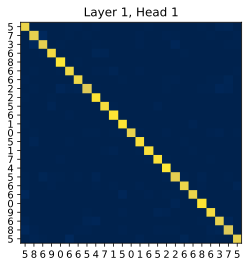

In [20]:
plot_attention_maps(data_input, attention_maps, idx=0)

The model has learned to attend to the token that is on the flipped index of itself. Hence, it actually does what we intended it to do. We see that it however also pays some attention to values close to the flipped index. This is because the model doesn't need the perfect, hard attention to solve this problem, but is fine with this approximate, noisy attention map. The close-by indices are caused by the similarity of the positional encoding, which we also intended with the positional encoding.

**ASIGNMENT**
Analyze the accuracy of the transformer in long sequences, e.g. increment *seq_len* with a step size of 50.

*optional:* replace transformer with a RNN and compare the accuracy with the same *seq_len*.